#  Natural Language Processing with Disaster Tweets 

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 35px; border-radius: 20px; color: white; text-align: center; box-shadow: 0 10px 30px rgba(0,0,0,0.2);">
    <h1 style="font-size: 3.5em; margin: 0; text-shadow: 3px 3px 6px rgba(0,0,0,0.3);"> Disaster Tweet Classification </h1>
    <p style="font-size: 1.5em; margin-top: 20px; opacity: 0.95;">Using ML & Deep Learning to Predict Real Disasters </p>
</div>

---

##  Project Overview

###  Goal:
Classify tweets as **real disasters**  or **not disasters** 

###  Our Journey:
1. **Data Exploration** - Understanding our dataset
2. **Preprocessing** - Cleaning text data  
3. **Baseline Model** - TF-IDF + Logistic Regression
4. **Advanced Model** - DistilBERT Transformer
5. **Evaluation** - Measuring performance
6. **Submission** - Final predictions


---
#  Section 1: Import Libraries

<div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Loading Our Toolkit</h2>
</div>


In [1]:
!pip install transformers<5.0.0,>=4.41.0

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
print("Import successful ✅")



/bin/bash: line 1: 5.0.0,: No such file or directory


2026-02-12 02:30:24.191273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770863424.426666      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770863424.492752      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770863425.078002      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770863425.078047      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770863425.078050      55 computation_placer.cc:177] computation placer alr

Import successful ✅


In [2]:
# ===============================
# Core Libraries
# ===============================
import numpy as np
import pandas as pd

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
#  Text Processing & NLP
# ===============================
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# ===============================
# Feature Extraction (ML)
# ===============================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ===============================
#  Machine Learning Models
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# ===============================
#  ML Evaluation
# ===============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# ===============================
#  Pipeline
# ===============================
from sklearn.pipeline import Pipeline

# ===============================
#  Deep Learning (TensorFlow / Keras)
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    GRU,
    Dense,
    Dropout,
    Conv1D,
    GlobalMaxPooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# ===============================
#  Transformers (BERT)
# ===============================
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

import torch

# ===============================
#  Saving / Loading
# ===============================
import joblib
import os


---
# Section 2: Load & Explore Data

<div style="background: linear-gradient(120deg, #89f7fe 0%, #66a6ff 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Loading Our Dataset</h2>
</div>

##  First Look


In [3]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


###  Target Variable


In [4]:
df['target'].unique()

array([1, 0])

### Dataset Information


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


---
#  Section 3: Data Preprocessing

<div style="background: linear-gradient(to right, #fa709a 0%, #fee140 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Cleaning Data</h2>
</div>

## Removing Unnecessary Columns


In [6]:
df.drop(columns=['keyword', 'location', 'id'], inplace=True)

###  Updated Columns


In [7]:
df.columns

Index(['text', 'target'], dtype='object')

###  Splitting Features & Target


In [8]:
X=df['text']
y=df['target']

###  Loading Test Data


In [9]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
X_test = test_df['text']

---
#  Section 4: Baseline Model (TF-IDF + Logistic Regression)

<div style="background: linear-gradient(to right, #4facfe 0%, #00f2fe 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Building Our First Model</h2>
</div>

##  Creating Pipeline


In [10]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=10000
    )),
    ('clf', LogisticRegression(max_iter=1000))
])


###  Train-Validation Split


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


###  Training the Model


In [12]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

###  Baseline Results


In [13]:
from sklearn.metrics import f1_score, classification_report

y_pred = pipeline.predict(X_val)

print("F1-score:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


F1-score: 0.7646573080099092
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       869
           1       0.83      0.71      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



---
##  Hyperparameter Tuning with GridSearch

Let's optimize our model parameters!


In [14]:
param_grid = {
    'tfidf__max_features': [15000, 20000, 30000],
    'clf__C': [1, 1.5, 2]
}

gs = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [1, 1.5, 2],
                         'tfidf__max_features': [15000, 20000, 30000]},
             scoring='f1')

###  Optimized Results


In [15]:
from sklearn.metrics import f1_score, classification_report

y_pred = gs.predict(X_val)

print("F1-score:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


F1-score: 0.7752442996742671
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       869
           1       0.83      0.73      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



---
#  Section 5: Advanced Model (DistilBERT)

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Deep Learning with Transformers</h2>
    <p>Using state-of-the-art DistilBERT model!</p>
</div>

##  Installing Required Packages


In [16]:
!pip install transformers datasets torch


## Tokenization


In [17]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
X_train = X.tolist()
y_train = y.tolist()
X_test = test_df['text'].tolist()
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

##  Creating PyTorch Dataset


In [18]:
import torch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(train_encodings, y_train)


##  Loading DistilBERT Model


In [19]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Configuration


In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    
    no_cuda=False,             
    fp16=True,                
    dataloader_num_workers=2,  
    
    # Logging
    logging_dir='./logs',
    logging_steps=50,
    
    # Evaluation & Saving
    eval_strategy="no",         
    save_steps=200,
    save_total_limit=2,
    
    # Learning rate
    learning_rate=5e-5,
    
    report_to="none",           
    disable_tqdm=False,         
)

##  Defining Metrics


##  Training the Model

This will take a few minutes with GPU acceleration! 


In [21]:
from sklearn.metrics import f1_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"f1": f1_score(p.label_ids, preds)}


---
#  Section 6: Model Evaluation

<div style="background: linear-gradient(to right, #fa709a 0%, #fee140 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Measuring Performance</h2>
</div>

## Making Predictions on Validation Set


###  F1-Score & Classification Report


In [22]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

 Using device: cuda


In [23]:
model = model.to(device)
print(f"Model moved to {device}")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics
)

print("\n Starting training on GPU...\n")
trainer.train()

print("\n Training completed!")

Model moved to cuda

 Starting training on GPU...



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,0.526200
100,0.439400
150,0.384100
200,0.415600
250,0.376800
300,0.298500
350,0.301500
400,0.302000
450,0.279700
500,0.249600


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0,


 Training completed!


In [24]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

print("Creating validation encodings...")

X_val_list = X_val.tolist()
y_val_list = y_val.tolist()

val_encodings = tokenizer(X_val_list, truncation=True, padding=True, max_length=128)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

val_dataset = TweetDataset(val_encodings, y_val_list)

Creating validation encodings...


In [25]:
print("\n Making predictions on validation set...")

predictions_output = trainer.predict(val_dataset)
y_pred = predictions_output.predictions.argmax(-1)


 Making predictions on validation set...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [26]:
print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)

f1 = f1_score(y_val_list, y_pred)
print(f"\n F1-Score: {f1:.4f}")


VALIDATION RESULTS

 F1-Score: 0.9441


---
#  Section 7: Creating Submission

<div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); padding: 25px; border-radius: 15px; color: white;">
    <h2> Final Predictions</h2>
</div>

##  Preparing Test Data

In [27]:
print("\n Classification Report:")
print("-"*60)
print(classification_report(y_val_list, y_pred, target_names=['Not Disaster (0)', 'Disaster (1)']))


 Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

Not Disaster (0)       0.94      0.98      0.96       869
    Disaster (1)       0.97      0.92      0.94       654

        accuracy                           0.95      1523
       macro avg       0.96      0.95      0.95      1523
    weighted avg       0.95      0.95      0.95      1523




 Confusion Matrix:
[[852  17]
 [ 54 600]]

 Confusion Matrix saved as 'confusion_matrix.png'


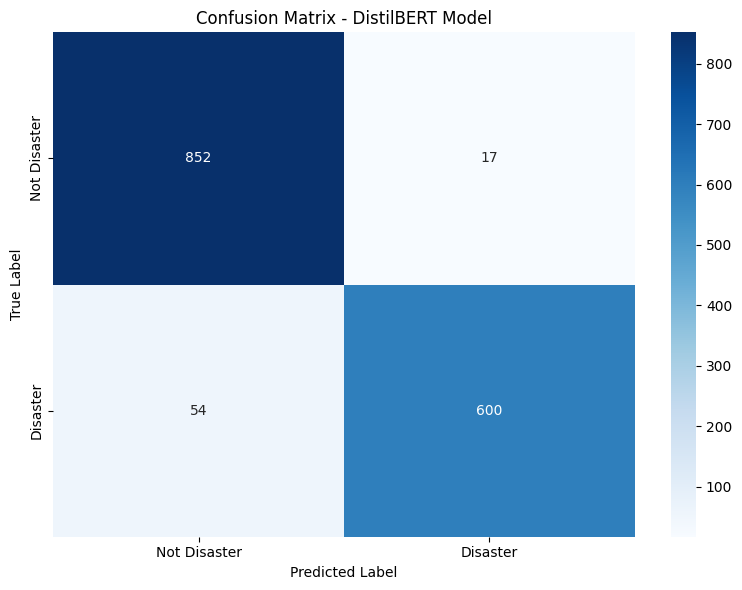

In [28]:
print("\n Confusion Matrix:")
cm = confusion_matrix(y_val_list, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix - DistilBERT Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n Confusion Matrix saved as 'confusion_matrix.png'")

In [29]:
print("\n" + "="*60)
print(" COMPARISON WITH BASELINE")
print("="*60)
print(f"Logistic Regression F1-Score: 0.7752")
print(f"DistilBERT F1-Score:          {f1:.4f}")

if f1 > 0.7752:
    improvement = ((f1 - 0.7752) / 0.7752) * 100
    print(f"\n Improvement: +{improvement:.2f}%")
else:
    decline = ((0.7752 - f1) / 0.7752) * 100
    print(f"\n Decline: -{decline:.2f}%")

print("\n" + "="*60)



 COMPARISON WITH BASELINE
Logistic Regression F1-Score: 0.7752
DistilBERT F1-Score:          0.9441

 Improvement: +21.79%



In [30]:
print("\n Sample Misclassifications:")
print("-"*60)

wrong_indices = [i for i in range(len(y_val_list)) if y_val_list[i] != y_pred[i]]

for i in wrong_indices[:5]:
    print(f"\nText: {X_val.iloc[i][:100]}...")
    print(f"True Label: {y_val_list[i]} | Predicted: {y_pred[i]}")
    print("-"*60)

print(f"\n Total misclassifications: {len(wrong_indices)} out of {len(y_val_list)}")
print(f"Accuracy: {(len(y_val_list) - len(wrong_indices)) / len(y_val_list):.4f}")



 Sample Misclassifications:
------------------------------------------------------------

Text: Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miner...
True Label: 1 | Predicted: 0
------------------------------------------------------------

Text: I can't drown my demons they know how to swim...
True Label: 1 | Predicted: 0
------------------------------------------------------------

Text: I agree with certain cultural appropriation things but honestly if u looked at my house it screams a...
True Label: 1 | Predicted: 0
------------------------------------------------------------

Text: The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr...
True Label: 1 | Predicted: 0
------------------------------------------------------------

Text: Newlyweds feed thousands of Syrian refugees instead of hosting a banquet wedding dinner -  http://t....
True Label: 1 | Predicted: 0
------------------------------------------

In [31]:
# Prepare test data
X_test = test_df['text'].tolist()
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

# Create dataset
test_dataset_tensors = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)

# Predictions
from torch.utils.data import DataLoader

model.eval()
model = model.to(device)
test_loader = DataLoader(test_dataset_tensors, batch_size=16)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(-1)
        all_preds.extend(predictions.cpu().numpy())

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': all_preds
})

submission.to_csv('submission.csv', index=False)
print("Submission file created!")
submission.head(10)

Submission file created!


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0




### Thank you for following along! 


In [ ]:
# Gradio Interface for Disaster Tweet Classifier
# Add this as your last cell in the notebook

import gradio as gr
import torch

# Make sure model is in eval mode and on the right device
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def predict_disaster(text):
    """
    Predict whether a tweet is about a real disaster or not.
    
    Args:
        text: Tweet text to classify
    
    Returns:
        Dictionary with prediction and confidence scores
    """
    # Tokenize the input
    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1).item()
    
    # Get confidence scores
    not_disaster_conf = probabilities[0][0].item()
    disaster_conf = probabilities[0][1].item()
    
    # Create result
    result = {
        "Not Disaster": not_disaster_conf,
        "Disaster": disaster_conf
    }
    
    return result

# Example tweets for testing
examples = [
    ["Just happened a terrible car crash"],
    ["I love sunny days at the beach!"],
    ["Earthquake strikes the city, buildings collapsing"],
    ["The new restaurant downtown is amazing"],
    ["Forest fire spreading rapidly near residential area"],
    ["Watching my favorite movie tonight"],
    ["Flood warning issued for the region"],
    ["Having coffee with friends"]
]

# Create Gradio interface
demo = gr.Interface(
    fn=predict_disaster,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Enter a tweet to classify...",
        label="Tweet Text"
    ),
    outputs=gr.Label(
        num_top_classes=2,
        label="Prediction"
    ),
    title="🚨 Disaster Tweet Classifier",
    description="""
    This model classifies tweets to determine if they're about real disasters or not.
    
    **Model:** DistilBERT fine-tuned on disaster tweets dataset
    
    Enter any tweet text and the model will predict:
    - **Disaster (1)**: Tweet is about a real disaster
    - **Not Disaster (0)**: Tweet is not about a real disaster
    """,
    examples=examples,
    theme=gr.themes.Soft(),
    allow_flagging="never"
)

# Launch the interface
demo.launch(share=True, debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://64c1f0b76940f3433e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
